# Module Import 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-06-06 02:03:09.572729: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 02:03:09.729265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 02:03:09.729343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 02:03:09.757227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 02:03:09.823413: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import pathlib
data_dir = r'DatasetCharacter'
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

37234


In [3]:
batch_size = 32
img_height = 40
img_width = 40

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 37234 files belonging to 36 classes.
Using 29788 files for training.


2024-06-06 02:03:14.694991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 02:03:14.885399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 02:03:14.885439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 02:03:14.890540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 02:03:14.890585: I external/local_xla/xla/stream_executor

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 37234 files belonging to 36 classes.
Using 7446 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


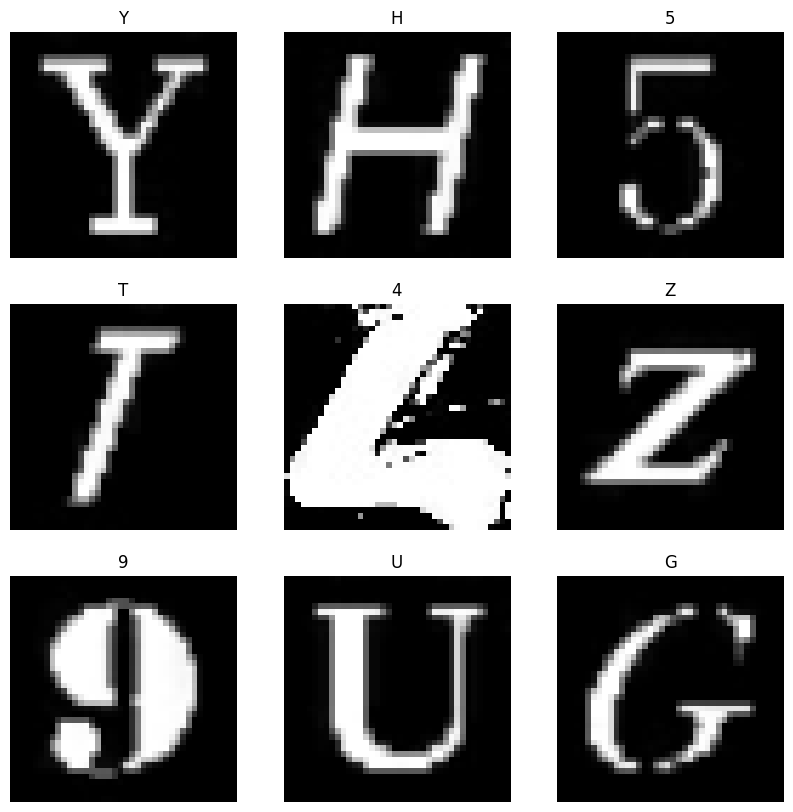

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 40, 40, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 40, 40, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        1

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2024-06-06 02:03:20.826798: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-06 02:03:21.039816: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-06 02:03:21.456651: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff3d4773d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 02:03:21.456688: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000, Compute Capability 8.6
2024-06-06 02:03:21.484475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717607001.645586  341603 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


931/931 [==============================] - 7s 5ms/step - loss: 0.5940 - accuracy: 0.8460 - val_loss: 0.2441 - val_accuracy: 0.9327
Epoch 2/10
931/931 [==============================] - 4s 4ms/step - loss: 0.1966 - accuracy: 0.9453 - val_loss: 0.1760 - val_accuracy: 0.9512
Epoch 3/10
931/931 [==============================] - 4s 4ms/step - loss: 0.1282 - accuracy: 0.9623 - val_loss: 0.1539 - val_accuracy: 0.9555
Epoch 4/10
931/931 [==============================] - 4s 4ms/step - loss: 0.0879 - accuracy: 0.9733 - val_loss: 0.1421 - val_accuracy: 0.9605
Epoch 5/10
931/931 [==============================] - 4s 4ms/step - loss: 0.0718 - accuracy: 0.9782 - val_loss: 0.1333 - val_accuracy: 0.9609
Epoch 6/10
931/931 [==============================] - 4s 4ms/step - loss: 0.0560 - accuracy: 0.9831 - val_loss: 0.1255 - val_accuracy: 0.9696
Epoch 7/10
931/931 [==============================] - 4s 4ms/step - loss: 0.0429 - accuracy: 0.9877 - val_loss: 0.1205 - val_accuracy: 0.9683
Epoch 8/10
931/93

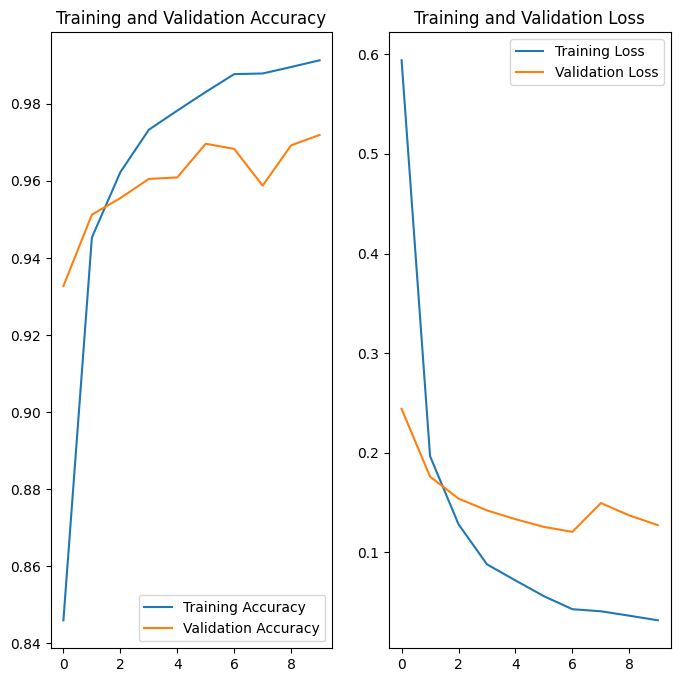

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.save('model128.h5')



In [21]:
from keras.models import load_model
loaded_model = load_model('model128.h5')